## Vehicles Detection

The goals / steps of this project are the following:

* Visualize the training data
* Extract the HOG features and Color Histogram features
* Build a SVC classifier to detect the vechicles
* Apply slide hog windows and predict the result in each windows
* Draw the heap diagram of prediction results
* Apply the threshold to remove the false positives
* Label the vehicles and draw onto the frame

### Import all the libraries needed

In [12]:
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import pickle
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import time
from sklearn.svm import LinearSVC
from sklearn import svm, grid_search
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

### Step1: Visualize the training data

In [13]:
# List of the car and notcar image file names.
cars = []
notcars = []

# Glob the car and notcar images
dirs = os.listdir('./data/vehicles')
for dir in dirs:
    car_images = glob.glob('./data/vehicles/' + dir + '/*.png')
    for image in car_images:
        cars.append(image)

# Glob the notcar images    
dirs = os.listdir('./data/non-vehicles')
for dir in dirs:
    notcar_images = glob.glob('./data/non-vehicles/' + dir + '/*.png')
    for image in notcar_images:
        notcars.append(image)

Dataset contains 8792 cars, 8968 non-cars of size: (64, 64, 3) and data type: float32


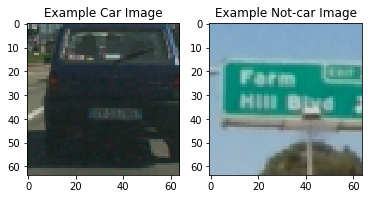

In [14]:
# Visualize the Dataset
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    img = mpimg.imread(notcar_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Dataset contains '+
      str(data_info["n_cars"]) + ' cars, ' +
      str(data_info["n_notcars"]) + ' non-cars' +
      ' of size: ' + str(data_info["image_shape"]) +
      ' and data type: ' + str(data_info["data_type"]))

# Plot 2 images
# Choose random car and notcar image 
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

### Step2: Extract feature vectors

In [15]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to convert the image to other color spaces
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2GRAY':
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orient, (pix_per_cell, pix_per_cell), (cell_per_block, cell_per_block), 
                                  visualise=True, transform_sqrt=True, feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orient, (pix_per_cell, pix_per_cell), (cell_per_block, cell_per_block), 
                                  visualise=False, transform_sqrt=True, feature_vector=feature_vec)
        return features

In [16]:
# Define a function to extract HOG and color histogram features.
def extract_features(img_paths, spatial_size=(32, 32), hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2, color='RGB2YCrCb', spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img_path in img_paths:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(img_path)
        
        # convert the image to YCrCb color space
        image = convert_color(image, 'RGB2YCrCb')
        
        #Compute spatial features if flag is set
        if spatial_feat == True:
            spatial_features = bin_spatial(image, size=spatial_size)
            # Append features to list
            file_features.append(spatial_features)
            
        #Compute histogram features if flag is set
        if hist_feat == True:
            # Training data is png readed by mpimg!
            hist_features = color_hist(image, nbins=hist_bins, bins_range=(0,1))
            # Append features to list
            file_features.append(hist_features)
            
        #Compute HOG features if flag is set
        if hog_feat == True:
            hog_features = []
            if color == 'RGB2GRAY':
                image = convert_color(image, 'RGB2GRAY')
                hog_features = get_hog_features(image, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            else:
                hog_features.append(get_hog_features(image[:,:,0], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
                hog_features.append(get_hog_features(image[:,:,1], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
                hog_features.append(get_hog_features(image[:,:,2], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [7]:
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size=(32, 32)
hist_bins=32

t=time.time()
car_features = extract_features(cars, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, color='RGB2YCrCb', spatial_feat=False, hist_feat=False, hog_feat=True)
notcar_features = extract_features(notcars, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, color='RGB2YCrCb', spatial_feat=False, hist_feat=False, hog_feat=True)
t2 = time.time()
print(len(car_features[0]))
print(round(t2-t, 2), 'Seconds to extract HOG features...')

5292
69.63 Seconds to extract HOG features...


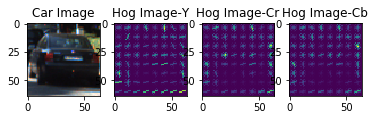

In [17]:
# Visualize the hog feature image
def visualize_hogfeatures(image):
        
    # convert the image to YCrCb color space
    cvt_image = convert_color(image, 'RGB2YCrCb')
        
    hog_features_Y, hog_image_Y = get_hog_features(cvt_image[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    hog_features_Cr, hog_image_Cr = get_hog_features(cvt_image[:,:,1], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    hog_features_Cb, hog_image_Cb = get_hog_features(cvt_image[:,:,2], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    
    fig = plt.figure()
    plt.subplot(141)
    plt.imshow(image)
    plt.title('Car Image')
    plt.subplot(142)
    plt.imshow(hog_image_Y)
    plt.title('Hog Image-Y')
    plt.subplot(143)
    plt.imshow(hog_image_Cr)
    plt.title('Hog Image-Cr')
    plt.subplot(144)
    plt.imshow(hog_image_Cb)
    plt.title('Hog Image-Cb')

# Choose random car image 
car_ind = np.random.randint(0, len(cars))
image = mpimg.imread(cars[car_ind])
visualize_hogfeatures(image)

### Step3: Training the model

In [9]:
# Preoperation the data
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [10]:
# Cross validation with GridSearchCV
parameters = {'C':[1,10]}
svr = LinearSVC()
clf = grid_search.GridSearchCV(svr, parameters)
# Check the training time for the SVC
t=time.time()
clf.fit(scaled_X, y)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train classifier ...')
# Best parameters and score of the SVC
print('Best parameters: ', clf.best_params_)
print('Best Score: ', round(clf.best_score_, 3))
print(clf.grid_scores_)

61.7 Seconds to train classifier ...
Best parameters:  {'C': 1}
Best Score:  0.924
[mean: 0.92410, std: 0.03414, params: {'C': 1}, mean: 0.92410, std: 0.03414, params: {'C': 10}]


In [11]:
# Save the Classfier and HOG features for later use.
dist_pickle = {}

# Classfier and Data preparation
dist_pickle["svc"] = clf
dist_pickle["scaler"] = X_scaler

# HOG features parameters
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["hog_color"] = True

pickle.dump( dist_pickle, open( "svc_pickle_color_linear.p", "wb" ) )

### Step4: Find cars with slide hog windows

In [18]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, boxs_list):
    # Attention: 
    # The svm model is trained with png image readed by mpimg.imread api, which will on a scale of 0~1,
    # The frame clipped from the video is jpg. After reading by mpimg.imread api, it will on a scale of 0~255,
    # therefore, the image need to scaled by 255.
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    #print('imgsize, nxblocks, nyblocks, nfeat_per_block: ',ch1.shape, nxblocks, nyblocks, nfeat_per_block)
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    #print("nxsteps, nysteps: ", nxsteps, nysteps)
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            #print(hog_feat1.shape, hog_feat2.shape, hog_feat3.shape, hog_features.shape)
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Scale features and make a prediction
            test_features = X_scaler.transform(hog_features.reshape(1, -1))
            test_prediction = clf.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxs_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))

In [19]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars_gray(img, ystart, ystop, scale, clf, X_scaler, orient, pix_per_cell, cell_per_block, boxs_list):
    # Attention: 
    # The svm model is trained with png image readed by mpimg.imread api, which will on a scale of 0~1,
    # The frame clipped from the video is jpg. After reading by mpimg.imread api, it will on a scale of 0~255,
    # therefore, the image need to scaled by 255.
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    gray = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2GRAY)
    if scale != 1:
        imshape = gray.shape
        gray = cv2.resize(gray, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # Define blocks and steps as above
    nxblocks = (gray.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (gray.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    #print('imgsize, nxblocks, nyblocks, nfeat_per_block: ',gray.shape, nxblocks, nyblocks, nfeat_per_block)
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    #print("nxsteps, nysteps: ", nxsteps, nysteps)
    
    # Compute individual channel HOG features for the entire image
    hog = get_hog_features(gray, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_features = hog[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack(hog_features).reshape(1, -1))        
            test_prediction = clf.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxs_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))

### Step5: Apply the heatmap to remove the false positives

In [20]:
# Draw the heatmap
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

# Update the heatmap with previous heatmap
def update_heat(last_heat, heat, new_heat_factor=0.3):
    return new_heat_factor * heat + (1-new_heat_factor) * last_heat

# Applying the threshold to the heatmap to filter the False Positives
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# Draw the labeled vehicles
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

### Visualize the result of each step

In [21]:
# Visualize the slide windows on the image.
def visualize_slidewindows(image, scales, winsize=(64,64)):
    # x,y
    img_size = (image.shape[1], image.shape[0])
    
    for scale in scales:
        scaled_winsize = (int(winsize[0] * scale['scale']), int(winsize[1] * scale['scale']))
        xsteps = int(img_size[0] / scaled_winsize[0])
        ysteps = int((scale['ystop'] - scale['ystart']) / scaled_winsize[1])
        
        for ystep in range(ysteps):
            for xstep in range(xsteps):
                topleft = (xstep * scaled_winsize[0], ystep * scaled_winsize[1] + scale['ystart'])
                downright = ((xstep+1) * scaled_winsize[0], (ystep+1) * scaled_winsize[1] + scale['ystart'])
                cv2.rectangle(image, topleft, downright, (0,0,255), 6)
    
    plt.imshow(image)
    plt.title('Slide windows')

# Visualize the prediction result.
def visualize_predictresult(image, boxs_list):
    draw_img = np.copy(image)
    
    for box in boxs_list:
        cv2.rectangle(draw_img, box[0], box[1], (0,0,255),6)

    plt.imshow(draw_img)

# Visualize the heatmap and final vehicle detection result.
def visualize_heatmap(heatmap, result):    
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    plt.subplot(122)
    plt.imshow(result)
    plt.title('Final Car Positions')
    #fig.tight_layout()

### VehicleTracker Class

In [37]:
class VehicleTracker:
    def __init__(self, frame_size=(720, 1280)):
        self.heat = np.zeros(frame_size)
        self.frames = []

    def process_frame(self, frame):
        # Image clipped from video and readed by mpimg.imread api is in jpg and 'RGB' format.
        heat = np.zeros_like(frame[:,:,0]).astype(np.float)
    
        # Scale the image with different size to find near and far vehicles.
        boxs_list = []
        for scale in scales:        
            # Find cars in boxs
            if hog_color == True:
                find_cars(frame, scale['ystart'], scale['ystop'], scale['scale'], svc, X_scaler, orient, pix_per_cell, cell_per_block, boxs_list)
            else:
                find_cars_gray(frame, scale['ystart'], scale['ystop'], scale['scale'], svc, X_scaler, orient, pix_per_cell, cell_per_block, boxs_list)

        # Visualize the Slide HOG Window Prediction result.
        #visualize_predictresult(frame, boxs_list)

        # Apply Heatmap of the boxs_list
        heat = add_heat(heat,boxs_list)
        
        # smooth with heatmap
        self.heat = update_heat(self.heat, heat)

        # Apply threshold to help removing false positives
        heat = apply_threshold(self.heat,4)
        
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)
        
        # Label the Heatmap to tackle with the multiple detections
        labels = label(heatmap)

        # Draw the final boxes
        result = draw_labeled_bboxes(np.copy(frame), labels)
        
        # visualization the heapmap result and final result
        visualize_heatmap(heatmap, result)

        return result

### Test on the images

In [23]:
# Prepare the parameters for the process_video
dist_pickle = pickle.load(open("svc_pickle_color_linear.p", "rb" ) )

# Classfier and Data preparation
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]

# Parameter for Hog features extraction
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
hog_color = dist_pickle["hog_color"]

#{'scale': 1,   'ystart': 400, 'ystop': 528},
scales = [{'scale': 1,    'ystart': 400, 'ystop': 528},
          {'scale': 1.25, 'ystart': 400, 'ystop': 576},
          {'scale': 1.5,  'ystart': 400, 'ystop': 576},
          {'scale': 2,    'ystart': 400, 'ystop': 656},
          {'scale': 3,    'ystart': 400, 'ystop': 656}]

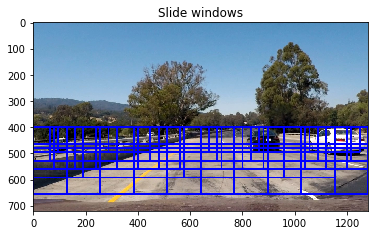

In [24]:
image = mpimg.imread('test_images/test1.jpg')
visualize_slidewindows(image, scales)

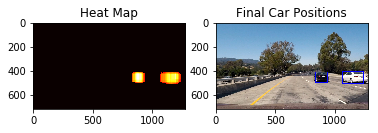

In [43]:
vehicleTracker1 = VehicleTracker()

image_files = glob.glob('test_images/test1.jpg')
for image_file in image_files:
    image = mpimg.imread(image_file)
    result = vehicleTracker1.process_frame(image)

### Test On the video

In [ ]:
vehicleTracker2 = VehicleTracker()

# Generate the video
project_video_output = 'output_videos/project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(vehicleTracker2.process_frame) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_video_output, audio=False)

In [ ]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(project_video_output))